## MNIST Classifier With Over 97% Accuracy

In [1]:
from sklearn.datasets import fetch_openml

minst = fetch_openml('mnist_784', as_frame=False)

/Users/parhamzam/miniforge3/envs/mlprojects/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
X, y = minst.data, minst.target

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

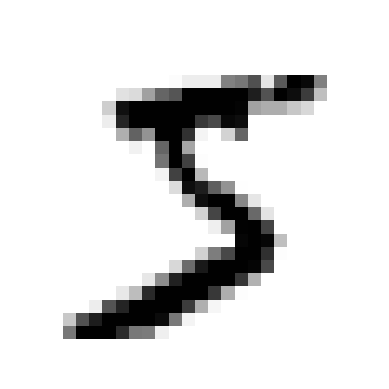

In [5]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
baseline_accuracy = knn.score(X_test, y_test)


In [8]:
baseline_accuracy

0.9688

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5 ,6]}]
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train[:10_000], y_train[:10_000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [10]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [11]:
grid_search.best_score_

0.9441999999999998

In [12]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9714

# Data Agumentation

In [ ]:
from scipy.ndimage import shift
from scipy.ndimage import rotate

In [28]:
def shift_image(image, dx, dy):
       image = image.reshape(28, 28)
       shifted_image = shift(image, [dx, dy], cval=0, mode="constant")
       return shifted_image.reshape([-1])

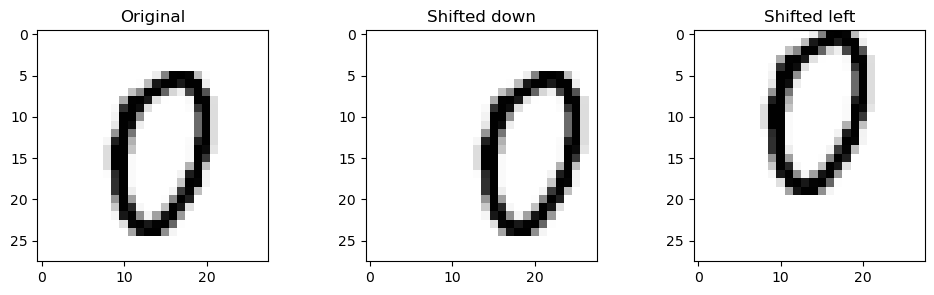

In [30]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

In [54]:
import numpy as np
rng = np.random.default_rng(42)  # remove or change seed for different runs

X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1,0), (0,1), (0, -1)):
       for image, label in zip(X_train, y_train):
              X_train_augmented.append(shift_image(image, dx, dy))
              y_train_augmented.append(label)

angle_min, angle_max = -15, 15   # tweak as you like
num_rotations_per_image = 1      # increase to generate more variants

for image, label in zip(X_train, y_train):
    img2d = image.reshape(28, 28)
    for _ in range(num_rotations_per_image):
        angle = rng.uniform(angle_min, angle_max)
        rotated = rotate(img2d, angle, reshape=False, mode="constant", cval=0, order=1)
        X_train_augmented.append(rotated.reshape(-1))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [55]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [56]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [57]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [58]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy
error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1
print(f"error_rate_change = {error_rate_change:.0%}")

error_rate_change = -21%


In [59]:
augmented_accuracy

0.9773